In [1]:
!echo $PATH

/Users/benjamin/anaconda3/envs/RIP/bin:/Users/benjamin/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin


In [220]:
%matplotlib inline
import pandas as pd
import os
import re
from pybedtools import BedTool
import numpy as np
import pybedtools
import re
import matplotlib.pyplot as plt
import json
import matplotlib
import subprocess
import numpy as np

In [154]:
#define your input folders
#define your input folders updated for haplotigs
EFFECTORP_FOLDER = '../../../genome_v03/annotation/functional/'
BUSCO_FOLDER = '../../../genome_v03/annotation/BUSCO/'
GFF_FOLDER = '../../../genome_v03/annotation/structural/'
GENOME_FOLDER = '../../genome/'
TE_FOLDER = '../../TE_analysis/'
EFFECTOR_FOLDER = '../../../genome_v03/effector_analysis'
PROTEIN_ANNO_FOLDER = '../../annotation/functional/'
AT_analysis = '../../AT_analysis'
OUT_FOLDER = os.path.join(AT_analysis, 'Dinucl')
TMP_FOLDER = os.path.join(OUT_FOLDER, 'difacount')
OUT_FOLDER_FIG = '../../figures/'
TMP_FIG_PATH = '../../../genome_v03/tmp_figures'
genome = 'APSI_primary_v1'
REPET_genome = 'MR_P2_a0'

In [5]:
if not os.path.exists(OUT_FOLDER):
    os.mkdir(OUT_FOLDER)

In [6]:
if not os.path.exists(TMP_FOLDER):
    os.mkdir(TMP_FOLDER)

In [12]:
#now get all the file names
genome_fn = os.path.join(GENOME_FOLDER, '%s.fa' %genome)
test_fn = os.path.join(TMP_FOLDER, 'test.fa')
!head {genome_fn} > {test_fn}

In [13]:
!head {test_fn}

>APSI_P001
ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCAATGTAATCTATATGAAAA
ATTAGATTTTTAATGAATTTTATAATATATCTCATATGAAAAAACTTTCACAATGTAATTCAATGAAAAA
AATATTTTTCAATACAATTCATATTGAAAATACGTATTTTTAGTGTAGTTTATATTGAAACTGCATTTTC
AGTGGTATTTTTTCAAAAAAAAATTCCATTTAATTTGCATCAATGATAAATTTGCAAATTAAATTTCTCT
TATATATATATTTCTTATTCAATGTATAGTCAAAATACATTTTTCAATTAATTTATATGCAAAATACATA
TATTAATGTGGTTTATGTTAAAAATAGTTTTCTTAATGTAGTTTATATTGAGAATACATCTCTAAATGTG
AGTTTTGTTCAAGACTGTATTACTAATGTAGTTTTTATTCATAAACATTTTTGAACTAATTTCTTATTAA
AAACACATCTCTCAATATAATTTATATGAGAAATATATTTTTCAATTTCATTCATATTCAAAATGCAGTT
GTTGATGAAATTATCATTAAACAACATTTTTCAATTTATTTAATATTACAAATACATATCCATATATATT


In [18]:
def facount(in_fn, out_fn):
    cmd = 'faCount -dinuc %s > %s' % \
    (os.path.abspath(in_fn), os.path.abspath(out_fn))
    output = subprocess.run(cmd, shell=True)
    return output.returncode

In [315]:
def do_RIP_call(fac_fn):
    "Return pandas dataframe with caculations reading in the faCount outfile."
    faC_header = ['seqID','len','A','C','G','T','N','cpg','AA','AC','AG',
                 'AT','CA','CC','CG','CT','GA','GC','GG','GT','TA','TC','TG','TT']
    count_dict = {}
    for n_pattern in faC_header:
        count_dict[n_pattern] = []
    dtypes = {}
    for x in faC_header:
        dtypes[x] = 'int'
    dtypes['seqID'] = 'str'
    with open(fac_fn) as fh: 
        for line in fh:
            line = line.rstrip()
            split_line = re.split(pattern, line)
            if not line.startswith('#'):
                #if len(split_line) > len(faC_header):
                  #  split_line = split_line[0:len(faC_header)+1]

                for n_pattern, value in zip(faC_header, split_line):
                    count_dict[n_pattern].append(value)
    df = pd.DataFrame.from_dict(count_dict)
    df = df.astype(dtypes)
    df['TpA/ApT'] = df['TA']/df['AT']
    df['CpA + TpG/ApC + GpT'] = (df['CA'] + df['TG'])/(df['AC']+df['GT'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [256]:
def AT_content_df(bed_fn, contig_fn, intervals, merge=True):
    bed = BedTool(bed_fn)
    if merge == True:
        bed.sort().merge()
    #specify datatypes if possible
    tmp_fn = bed_fn.replace('.bed', '.AT.bed.tmp')
    dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
    bed.nucleotide_content(fi=contig_fn).saveas(tmp_fn)
    #bedtools nuc -fi {contig_fn} -bed {bed_fn} > {tmp_fn}
    
    if len(bed.to_dataframe().columns) == 6:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:str, 4:str, 5:str, 6:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3,6], skiprows=1)
        df.rename(columns={6:'%AT'}, inplace=True)
    elif len(bed.to_dataframe().columns) == 3:
        dtype_dict = {0:str, 1:np.int32, 2:np.int32, 3:float}
        df = pd.read_csv( tmp_fn, sep='\t',header=None,dtype=dtype_dict, usecols=[0,1,2,3], skiprows=1)
        df.rename(columns={3:'%AT'}, inplace=True)
    df['%AT'] = df['%AT'].astype('float')
    df['W_Len'] = df[2] - df[1]
    
    df['Intervals'] = pd.cut(df['%AT'], intervals)
    grouped = df.groupby('Intervals')
    ###group by the edge
    ####get the length of the intervals and plot the sum for each interval
    ###edge
    
    
    sum_df = grouped.agg({'%AT': 'count', 'W_Len': 'sum'})
    sum_df['Interval_edge'] = intervals.right
    sum_df.fillna(0, inplace=True)
    sum_df['norm_count_AT'] = sum_df['%AT']/sum_df['%AT'].sum()
    sum_df['norm_W_Len'] = sum_df['W_Len']/sum_df['W_Len'].sum()
    os.remove(tmp_fn)
    return df, sum_df

In [175]:
repet_genome_fn = os.path.join(AT_analysis, '%s.repet.fa' % genome)
with open(genome_fn, 'r') as g_fh:
    with open(repet_genome_fn, 'w') as rg_fh:
        for line in g_fh:
            line = line.rstrip('\n')
            if line.startswith(">"):
                line = line.replace('APSI_P0','ApsiP_S00')
                print(line, file = rg_fh)
            else:
                print(line, file = rg_fh)

In [176]:
!head {repet_genome_fn}

>ApsiP_S0001
ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCAATGTAATCTATATGAAAA
ATTAGATTTTTAATGAATTTTATAATATATCTCATATGAAAAAACTTTCACAATGTAATTCAATGAAAAA
AATATTTTTCAATACAATTCATATTGAAAATACGTATTTTTAGTGTAGTTTATATTGAAACTGCATTTTC
AGTGGTATTTTTTCAAAAAAAAATTCCATTTAATTTGCATCAATGATAAATTTGCAAATTAAATTTCTCT
TATATATATATTTCTTATTCAATGTATAGTCAAAATACATTTTTCAATTAATTTATATGCAAAATACATA
TATTAATGTGGTTTATGTTAAAAATAGTTTTCTTAATGTAGTTTATATTGAGAATACATCTCTAAATGTG
AGTTTTGTTCAAGACTGTATTACTAATGTAGTTTTTATTCATAAACATTTTTGAACTAATTTCTTATTAA
AAACACATCTCTCAATATAATTTATATGAGAAATATATTTTTCAATTTCATTCATATTCAAAATGCAGTT
GTTGATGAAATTATCATTAAACAACATTTTTCAATTTATTTAATATTACAAATACATATCCATATATATT


In [177]:
!samtools faidx {repet_genome_fn}

In [178]:
!cut -f1,2 {repet_genome_fn}.fai > {repet_genome_fn.replace('.fa', '.genome')}

In [182]:
repet_genome_index_fn = os.path.abspath(repet_genome_fn.replace('.fa', '.genome'))

In [152]:
repet_gff_fn = os.path.join(TE_FOLDER, 'APSI_primary_v1.MR_P2A_300Mb.REPET.gff3' )
repet_bed_reverse_fn = repet_gff_fn.replace('.gff3', '.reverse.nr.bed')
pybedtools.BedTool(repet_gff_fn).sort().merge().\
complement(g=repet_genome_index_fn).saveas(repet_bed_reverse_fn)

<BedTool(../../TE_analysis/APSI_primary_v1.MR_P2A_300Mb.REPET.reverse.nr.bed)>

In [185]:
repet_bed_flies = []
for folder in ['Retrotransposon', 'DNA_transposon']:
    for file in os.listdir(os.path.join(TE_FOLDER, folder)):
        if file.endswith('.nr.bed') and file.split('.')[3] == 'superfamily':
            repet_bed_flies.append(os.path.join(TE_FOLDER, folder, file))
repet_bed_flies.append(repet_bed_reverse_fn)


In [298]:
facount_fa_files = []
for tmp_bed_fn in repet_bed_flies:
    tmp_bed = BedTool(tmp_bed_fn)
    tmp_out_fn = os.path.join(TMP_FOLDER, os.path.basename(tmp_bed_fn)\
                              .replace('.bed', '.fa'))
    tmp_bed.sequence(fi=repet_genome_fn).save_seqs(tmp_out_fn)
    facount_fa_files.append(tmp_out_fn)

In [196]:
!ls {EFFECTOR_FOLDER}

APSI_primary_v1.MR_P2A_300Mb.REPET.gff3
APSI_primary_v1.anno.gff
APSI_primary_v1.transcript.busco.bed
APSI_primary_v1.transcript.effector.bed
APSI_primary_v1.transcript.genes.bed
APSI_primary_v1.transcript.nob_noe.bed
APSI_primary_v1.transcript.nobusco.bed
APSI_primary_v1.transcript.noeffector.bed


In [ ]:
#pulling in the AT files based on occulter_cut
intervals = pd.interval_range(start=0.2, end=1.0, closed='right', periods=80)
oc_bed_fn = os.path.join(AT_analysis, 'regions.bed')

oc_df, oc_sum_df = AT_content_df(oc_bed_fn, genome_fn, intervals)
oc_greater_fn = os.path.join(AT_analysis, 'Greater_61%AT_regions.bed')
oc_smaller_fn = os.path.join(AT_analysis, 'Smaller_61%AT_regions.bed')

oc_df[oc_df['%AT'] > 0.61].iloc[:, 0:3].to_csv(os.path.join(oc_greater_fn \
                                               , index=None, header=None, sep='\t')
oc_df[(oc_df['%AT'] < 0.61)|(oc_df['%AT'] == 0.61)].iloc[:, 0:3].to_csv(oc_smaller_fn,\
                                                                        index=None, header=None, sep='\t')

In [301]:
bed_files = []
bed_files.append(os.path.join(EFFECTOR_FOLDER, 'APSI_primary_v1.transcript.genes.bed'))
bed_files.append(oc_greater_fn)
bed_files.append(oc_smaller_fn)

In [302]:
for tmp_bed_fn in bed_files:
    tmp_bed = BedTool(tmp_bed_fn)
    tmp_out_fn = os.path.join(TMP_FOLDER, os.path.basename(tmp_bed_fn)\
                              .replace('.bed', '.fa'))
    tmp_bed.sequence(fi=genome_fn).save_seqs(tmp_out_fn)
    facount_fa_files.append(tmp_out_fn)

In [303]:
facount_fa_files

['../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:?:?.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:SINE:5S.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:Gypsy.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:?.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:DIRS:DIRS.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LINE:Jockey.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LINE:L1.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LARD:?.nr.fa',
 '../../AT_analysis/Dinucl/difacount/APSI_primary_v1.MR_P2A_300Mb.REPET.superfamily.ClassI:LTR:Retrovirus.nr.fa',
 '../../AT_analysis/Dinucl/di

In [316]:
facount_fac_files = []
#'TpA/ApT'
dicount_dict_S = {}
#'CpA + TpG/ApC + GpT'
dicount_dict_L = {}
#length
dicount_dict_length = {}
for file in facount_fa_files:
    tmp_out_fn = file.replace('.fa', '.fac')
    facount(file, tmp_out_fn)
    facount_fac_files.append(tmp_out_fn)
    tmp_df = do_RIP_call(tmp_out_fn)
    if 'superfamily' in file:
        name = os.path.basename(file).split('.')[4]
    elif 'REPET.reverse.nr.' in file:
        name = 'non_TE'
    elif 'transcript.genes' in file:
        name = 'genes'
    elif '%AT_regions' in file:
        name = os.path.basename(file).split('.')[0]
    dicount_dict_S[name] = tmp_df['TpA/ApT']
    dicount_dict_L[name] = tmp_df['CpA + TpG/ApC + GpT']
    dicount_dict_length[name] = tmp_df['len']

In [317]:
dicount_dict_S.keys()

dict_keys(['ClassI:?:?', 'ClassI:SINE:5S', 'ClassI:LTR:Gypsy', 'ClassI:LTR:?', 'ClassI:DIRS:DIRS', 'ClassI:LINE:Jockey', 'ClassI:LINE:L1', 'ClassI:LARD:?', 'ClassI:LTR:Retrovirus', 'ClassI:DIRS:?', 'ClassI:LINE:RTE', 'ClassI:LINE:R2', 'ClassI:LTR:Bel-Pao', 'ClassI:LINE:I', 'ClassI:LTR:Copia', 'ClassI:PLE:Penelope', 'ClassI:TRIM:?', 'ClassI:SINE:?', 'ClassI:LTR:ERV', 'ClassI:LINE:?', 'ClassII:TIR:CACTA', 'ClassII:TIR:PIF-Harbinger', 'ClassII:?:Kolobok', 'ClassII:Helitron:?', 'ClassII:TIR:P', 'ClassII:MITE:?', 'ClassII:TIR:PiggyBac', 'ClassII:TIR:hAT', 'ClassII:TIR:Transib', 'ClassII:TIR:MuDR', 'ClassII:TIR:Tc1-Mariner', 'ClassII:Crypton:Crypton', 'ClassII:Maverick:Maverick', 'ClassII:?:Ginger2_TDD', 'ClassII:Helitron:Helitron', 'ClassII:?:Ginger1', 'ClassII:TIR:?', 'ClassII:Maverick:?', 'ClassII:?:?', 'ClassII:?:Novosib', 'ClassII:?:Sola', 'non_TE', 'genes', 'Greater_61%AT_regions', 'Smaller_61%AT_regions'])

In [321]:
for x in ['non_TE', 'genes', 'ClassI:LTR:Gypsy','ClassI:LTR:Copia', 'Greater_61%AT_regions', 'Smaller_61%AT_regions'] :
    print(x, ': ', dicount_dict_S[x][:-1].describe())
    #print(x, ': ', dicount_dict_S[x].iloc[-1])

non_TE :  count    245341.000000
mean          0.788108
std           0.390943
min           0.000000
25%           0.629630
50%           0.777778
75%           0.931034
max          47.000000
Name: TpA/ApT, dtype: float64
genes :  count    18479.000000
mean         0.660514
std          0.727614
min          0.000000
25%          0.563857
50%          0.651099
75%          0.737234
max         96.076923
Name: TpA/ApT, dtype: float64
ClassI:LTR:Gypsy :  count    336982.000000
mean          0.733147
std           0.335770
min           0.000000
25%           0.548872
50%           0.750000
75%           0.878378
max          36.000000
Name: TpA/ApT, dtype: float64
ClassI:LTR:Copia :  count    75249.000000
mean         0.770200
std          0.370810
min          0.000000
25%          0.571429
50%          0.764085
75%          0.928571
max          6.000000
Name: TpA/ApT, dtype: float64
Greater_61%AT_regions :  count    91188.000000
mean         0.812349
std          0.107013
min       

In [314]:
for x in  dicount_dict_S.keys():
    print(x, ': ', dicount_dict_S[x][:-1].median())

ClassI:?:? :  1.0
ClassI:SINE:5S :  1.6666666666666667
ClassI:LTR:Gypsy :  0.75
ClassI:LTR:? :  0.75
ClassI:DIRS:DIRS :  0.6923076923076923
ClassI:LINE:Jockey :  0.7142857142857143
ClassI:LINE:L1 :  0.5527777777777778
ClassI:LARD:? :  0.8181818181818182
ClassI:LTR:Retrovirus :  0.75
ClassI:DIRS:? :  0.8333333333333334
ClassI:LINE:RTE :  0.8916666666666666
ClassI:LINE:R2 :  0.8333333333333334
ClassI:LTR:Bel-Pao :  0.17902930402930403
ClassI:LINE:I :  0.7860696517412935
ClassI:LTR:Copia :  0.7640845070422535
ClassI:PLE:Penelope :  74.5
ClassI:TRIM:? :  0.8221688034188034
ClassI:SINE:? :  0.5594117647058824
ClassI:LTR:ERV :  0.6666666666666666
ClassI:LINE:? :  0.7898550724637681
ClassII:TIR:CACTA :  0.6
ClassII:TIR:PIF-Harbinger :  0.682983682983683
ClassII:?:Kolobok :  0.6551724137931034
ClassII:Helitron:? :  0.75
ClassII:TIR:P :  0.5954545454545455
ClassII:MITE:? :  0.6923076923076923
ClassII:TIR:PiggyBac :  1.0454545454545454
ClassII:TIR:hAT :  0.6590909090909091
ClassII:TIR:Transib : 

In [326]:
for x in ['non_TE', 'genes', 'ClassI:LTR:Gypsy','ClassI:LTR:Copia', 'Greater_61%AT_regions', 'Smaller_61%AT_regions'] :
    print(x, ': ', dicount_dict_L[x][:-1].describe())
    #print(x, ' #elements:', len(dicount_dict_L[x][:-1]))
    #last_element = len(dicount_dict_S[x] - 1)
    #print(x, ': ', dicount_dict_L[x].iloc[-1])

non_TE :  count    246278.000000
mean          1.547403
std           0.715196
min           0.000000
25%           1.200000
50%           1.480000
75%           1.764706
max          14.000000
Name: CpA + TpG/ApC + GpT, dtype: float64
genes :  count    18481.000000
mean         1.512090
std          0.491690
min          0.000000
25%          1.339623
50%          1.468750
75%          1.636364
max         56.000000
Name: CpA + TpG/ApC + GpT, dtype: float64
ClassI:LTR:Gypsy :  count    336838.000000
mean          1.649068
std           0.713452
min           0.000000
25%           1.307692
50%           1.500000
75%           1.818182
max          52.000000
Name: CpA + TpG/ApC + GpT, dtype: float64
ClassI:LTR:Copia :  count    75213.000000
mean         1.638833
std          0.801637
min          0.000000
25%          1.250000
50%          1.474453
75%          1.800000
max         22.000000
Name: CpA + TpG/ApC + GpT, dtype: float64
Greater_61%AT_regions :  count    91175.000000
mean  

{'whiskers': [<matplotlib.lines.Line2D at 0x11d747850>,
 'caps': [<matplotlib.lines.Line2D at 0x11d74bed0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11d747810>],
 'medians': [<matplotlib.lines.Line2D at 0x11d74d950>],
 'fliers': [<matplotlib.lines.Line2D at 0x11d74de50>],
 'means': []}

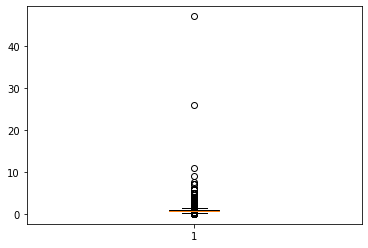

In [238]:
plt.boxplot(dicount_dict_S['non_TE'].dropna())

In [313]:
#maybe do the rip analysis by family instead
#maybe consider doing reverse complements as well